<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
RunningInCOLAB

False

In [2]:
if RunningInCOLAB:
    try:
      # %tensorflow_version only exists in Colab.
      %tensorflow_version 2.x
    except Exception:
      pass
else: 
    import tensorflow as tf
    tf_version = tf.__version__
    print(tf_version)

2.3.0


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [4]:
def trend(time, slope=0):
    return slope * time

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
series

array([0.0000000e+00, 1.0000000e-01, 2.0000000e-01, ..., 1.4580000e+02,
       1.4590001e+02, 1.4600000e+02], dtype=float32)

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

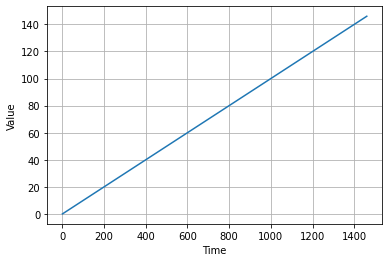

In [6]:
plot_series(time,series)

In [7]:
amplitude = 50
slope = 0.05
noise_level = 10

In [8]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    #np.cos(season_time * 2 * np.pi),
                    np.sin(season_time * 2),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

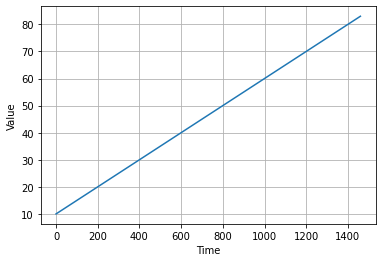

In [9]:
series = baseline + trend(time, slope)
plot_series(time,series)

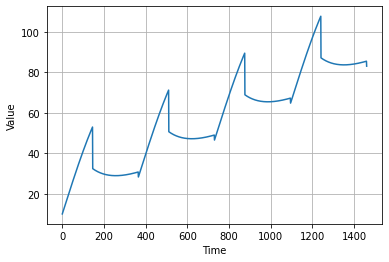

In [11]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
plot_series(time,series)

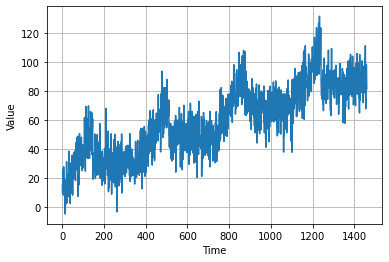

In [12]:
series += noise(time, noise_level, seed=42)
plot_series(time,series)

In [14]:
series

array([14.967141,  8.941329, 17.12482 , ..., 98.32814 , 92.19171 ,
       81.61544 ], dtype=float32)

In [15]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [18]:
layer1 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([layer1])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(layer1.get_weights()))

Layer weights [array([[-0.04179691],
       [ 0.01390895],
       [ 0.05187754],
       [-0.00667344],
       [ 0.02397791],
       [ 0.01702318],
       [ 0.01299406],
       [ 0.03249782],
       [ 0.04356273],
       [ 0.07468393],
       [ 0.06431089],
       [ 0.08841836],
       [ 0.00521288],
       [ 0.07662527],
       [ 0.08580333],
       [ 0.10871445],
       [ 0.02500525],
       [ 0.1001057 ],
       [ 0.09689617],
       [ 0.10136181]], dtype=float32), array([0.01869123], dtype=float32)]


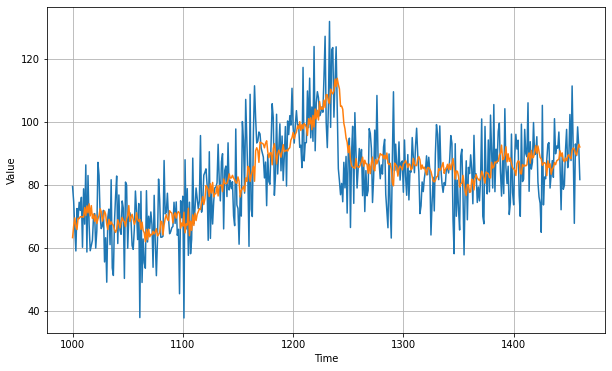

In [24]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.558071

In [44]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

145.66315